In [2]:
import os
import copy
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io
import matplotlib.pyplot as plt
import glob
import re
from datetime import datetime
from dateutil import parser
import dateutil.parser
from scipy.io import savemat

import numpy as np
import scipy.misc
import numpy.random as rng
from PIL import Image, ImageDraw, ImageFont
from sklearn.utils import shuffle
import nibabel as nib #reading MR images
import math
from matplotlib import pyplot as plt

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU
from keras.optimizers import SGD, Adam
import tensorflow as tf
import shap
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError


### Regression

Epoch 1/50
51/51 [==============================] - 0s 3ms/step - loss: 0.0536 - mean_absolute_error: 0.1035 - val_loss: 5.0773e-05 - val_mean_absolute_error: 0.0035
Epoch 2/50
51/51 [==============================] - 0s 1ms/step - loss: 2.8034e-04 - mean_absolute_error: 0.0059 - val_loss: 3.3425e-05 - val_mean_absolute_error: 0.0030
Epoch 3/50
51/51 [==============================] - 0s 1ms/step - loss: 2.2727e-04 - mean_absolute_error: 0.0053 - val_loss: 2.6588e-05 - val_mean_absolute_error: 0.0028
Epoch 4/50
51/51 [==============================] - 0s 1ms/step - loss: 2.1513e-04 - mean_absolute_error: 0.0049 - val_loss: 2.0485e-05 - val_mean_absolute_error: 0.0026
Epoch 5/50
51/51 [==============================] - 0s 1ms/step - loss: 1.6121e-04 - mean_absolute_error: 0.0043 - val_loss: 1.7131e-05 - val_mean_absolute_error: 0.0025
Epoch 6/50
51/51 [==============================] - 0s 1ms/step - loss: 9.6262e-05 - mean_absolute_error: 0.0037 - val_loss: 1.3979e-05 - val_mean_absolut

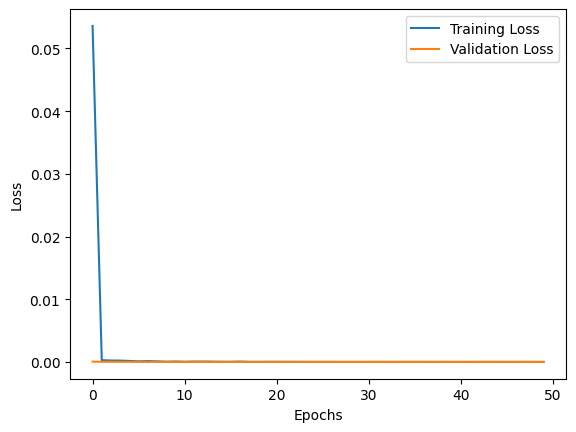

16/16 [==============================] - 0s 600us/step
Mean Absolute Error: 0.002056119875116745
R-squared: -21.746818837528238
Mean Percentage Error on Test Set: 97.0332%

Actual vs Predicted:
        Actual     Predicted
56    0.001567  2.229206e-05
194   0.001440  8.318138e-08
2225  0.002216  6.151922e-08
233   0.002248  5.433520e-05
1902  0.001589  1.889512e-05
...        ...           ...
2296  0.002643  9.029451e-10
1127  0.001835  2.227771e-07
2456  0.002528  9.606818e-13
1915  0.002439  7.403542e-05
841   0.002566  1.543700e-06

[510 rows x 2 columns]


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


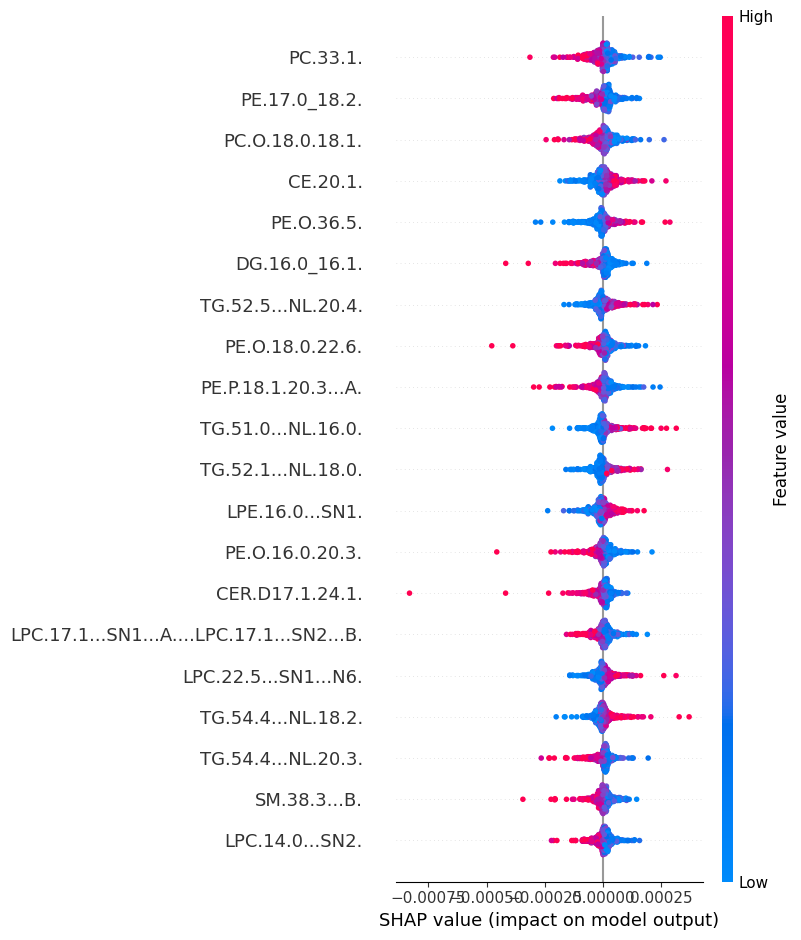

In [8]:
DATASET = 'Dataset3.0.csv'
dataset = pd.read_csv(DATASET)
dataset['Sex'] = dataset['Sex'].replace({'M': 1, 'F': 0})
lipids_only = dataset.iloc[:, list(range(54, 837))]
columns_to_drop = ['LHC_ICV', 'RHC_ICV']
X = lipids_only.drop(columns=columns_to_drop, axis=1)
y = lipids_only['LHC_ICV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = tf.convert_to_tensor(y_true), tf.convert_to_tensor(y_pred)
    return tf.reduce_mean(tf.abs((y_true - y_pred) / tf.maximum(tf.abs(y_true), 1e-8))) * 100

# Define the model
model = Sequential([
    Dense(100, input_shape=(X_train.shape[1],)), LeakyReLU(alpha=0.01),
    Dropout(0.5),
    Dense(60, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=MeanSquaredError(),  # Mean Squared Error for regression
              metrics=[MeanAbsoluteError()])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict probabilities
y_pred = model.predict(X_test_scaled).flatten()

# Evaluate the model performance using Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("R-squared:", r2)

def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

mape = MAPE(y_test, y_pred)
print(f"Mean Percentage Error on Test Set: {mape:.4f}%")

output_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print("\nActual vs Predicted:")
print(output_df)

explainer = shap.GradientExplainer(model, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values[0], X_test_scaled, feature_names=X_test.columns, plot_type="dot")